In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.insert(0, "python")
from network import *
from protocols import *
from adversary import *
from simulator import *

/home/fberes/.conda/envs/ethsim/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dandelion example

In [14]:
net = Network(20, 4)

In [15]:
dp = DandelionProtocol(net, 0.1)

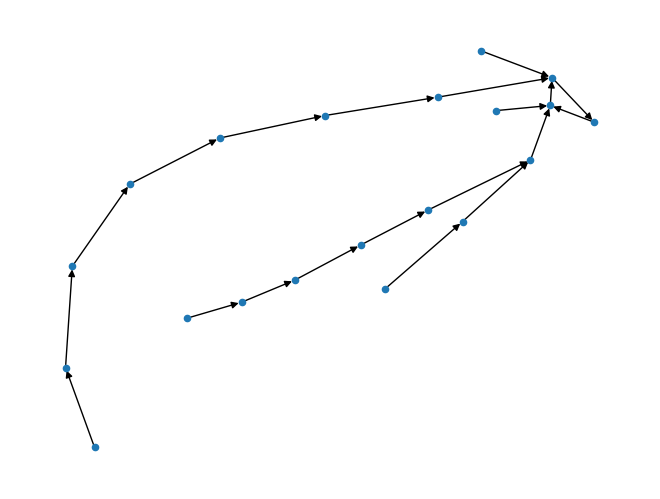

In [27]:
nx.draw(dp.line_graph, node_size=20)

In [28]:
adv = Adversary(net, 0.1)
sim = Simulator(dp, adv, 10, verbose=False)
sim.run(coverage_threshold=0.95)

In [30]:
evaluator = Evaluator(sim)
print(evaluator.get_report())

{'hit_ratio': 0.1, 'mean_inverse_rank': 0.11139720558882235, 'entropy': 0.5991464547107981, 'message_spread_ratio': 0.7}


# Experiment example

In [19]:
def run_and_eval(net: Network, adv: Adversary, protocol: Protocol):
    sim = Simulator(protocol, adv, int(network_size / 10), verbose=False)
    sim.run()
    evaluator = Evaluator(sim)
    report = evaluator.get_report()
    report["protocol"] = str(protocol)
    report["adversary_ratio"] = adv_ratio
    return report

In [31]:
network_size = 1000
degree = 50
num_trials = 5#10
adversary_ratios = [0.01,0.025,0.05,0.075,0.1]
results = []

In [32]:
%%time
# it could be parallelized
for adv_ratio in adversary_ratios:
    for _ in range(num_trials):
        # this part cannot be parallelized: it is important that different protocols will be evaluated with the same network and adversary setting
        net = Network(network_size, degree)
        adv = Adversary(net, adv_ratio)
        # BUT: messages won't be the same!!!
        results.append(run_and_eval(net, adv, BroadcastProtocol(net)))
        results.append(run_and_eval(net, adv, DandelionProtocol(net, 0.5)))
        results.append(run_and_eval(net, adv, DandelionProtocol(net, 0.25)))
    print(adv_ratio)

0.01
0.025
0.05
0.075
0.1
CPU times: user 3min 57s, sys: 837 ms, total: 3min 58s
Wall time: 3min 58s


In [33]:
import seaborn as sns

In [34]:
results_df = pd.DataFrame(results)
results_df.head()

,hit_ratio,mean_inverse_rank,entropy,message_spread_ratio,protocol,adversary_ratio
0,0.23,0.231537,0.0,0.92804,BroadcastProtocol(),0.01
1,0.05,0.051896,0.0,0.92724,DandelionProtocol(0.5000),0.01
2,0.06,0.061876,0.0,0.92472,DandelionProtocol(0.2500),0.01
3,0.11,0.111776,0.0,0.92906,BroadcastProtocol(),0.01
4,0.09,0.091816,0.0,0.92703,DandelionProtocol(0.5000),0.01


### Dummy adversary predicts message source for Dandelion much worse than in case of ismple broadcasting

<AxesSubplot: xlabel='adversary_ratio', ylabel='hit_ratio'>

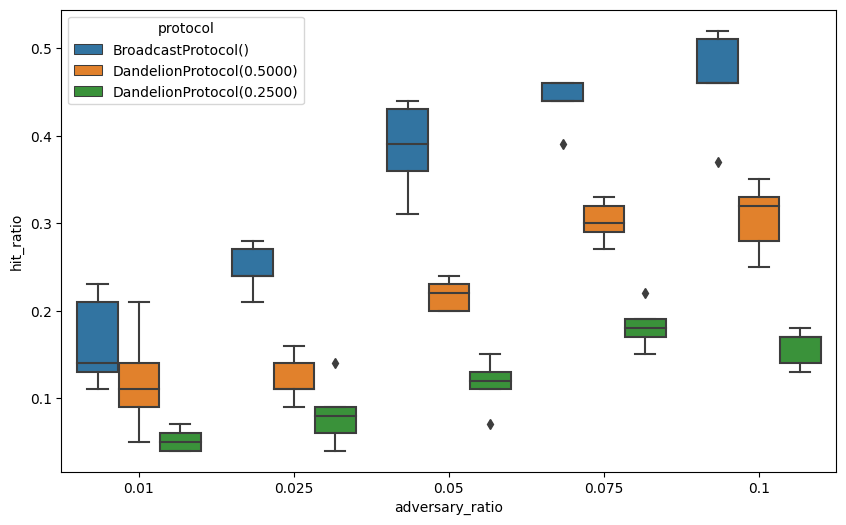

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.boxplot(data=results_df, x="adversary_ratio", y="hit_ratio", hue="protocol", ax=ax)

### While the fraction of nodes reached by messages are the same range for all protocols

<AxesSubplot: xlabel='adversary_ratio', ylabel='message_spread_ratio'>

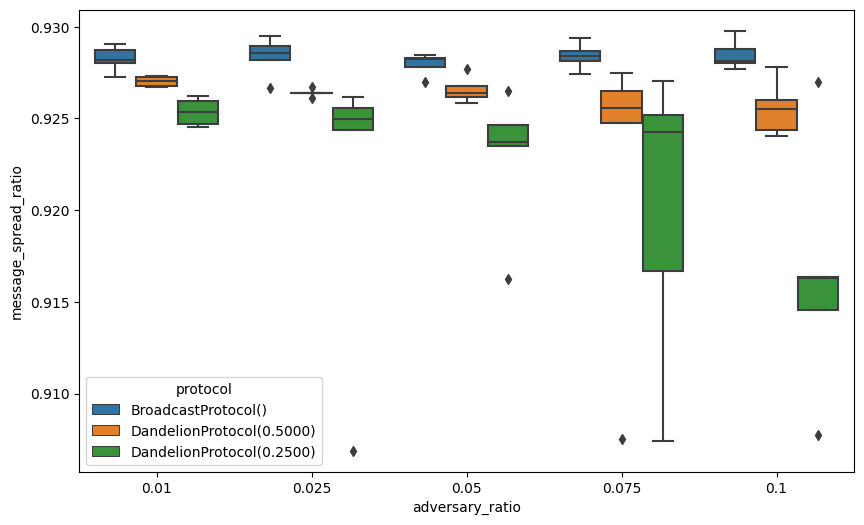

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.boxplot(data=results_df, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax)